In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio as rio
from scipy.optimize import curve_fit
from sklearn import metrics
import rasterstats
from itertools import product
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix, mean_absolute_error

In [2]:
cd /home/micromamba/data/spot

/home/micromamba/data/spot


In [3]:
def linear(x,a):
    return a*x

def calculate_rate(df,location='start'):
    df['years'] = (df.date - df.date.min()).dt.days / 365.25

    rates = pd.DataFrame()
    names = df.name.unique()

    for name in names:
        # Grab data
        loc = df.loc[df.name==name].copy()

        # Get yearly peg displacement rate
        n_rate = curve_fit(linear,loc['years'],loc['cum_n_disp'])[0][0]
        e_rate = curve_fit(linear,loc['years'],loc['cum_e_disp'])[0][0]
        
        # tdiff = loc.years.max() - loc.years.min()
        # e_rate = loc['cum_e_disp'].max() / tdiff
        # n_rate = loc['cum_n_disp'].max() / tdiff
        
        if location == 'start':
            min_date = loc.date.min()
            e = float(loc.loc[loc.date==min_date,'east'])
            n = float(loc.loc[loc.date==min_date,'north'])
        elif location == 'average':
            e = loc.east.mean()
            n = loc.north.mean()
        elif location == 'end':
            max_date = loc.date.max()
            e = float(loc.loc[loc.date==max_date,'east'])
            n = float(loc.loc[loc.date==max_date,'north'])
        
        row = {'name':name,'e_rate':e_rate,'n_rate':n_rate,'east':e,'north':n}
        rates = rates.append(row,ignore_index=True)
    
    points = gpd.points_from_xy(rates['east'],rates['north'],crs='EPSG:32760')
    rates_geo = gdf = gpd.GeoDataFrame(rates, geometry=points)
    return rates_geo

In [4]:
bird_point = gpd.read_file('validation/bird_point_tracking.shp')
rang_point = gpd.read_file('validation/rangitikei_pegs.shp')

In [5]:
rang_point = rang_point.drop(columns=['elev','e_disp','n_disp','v_disp','cum_v_disp'])
rang_point['date'] = pd.to_datetime(rang_point.date)

In [6]:
bird_point = bird_point.rename(columns={'id':'name','year':'date','easting':'east','northing':'north'})
bird_point['name'] = 'Peg ' + bird_point.name.astype(str)

In [7]:
cps = bird_point.loc[bird_point['type']=='c'].copy().pivot(
    index='name', columns='date', values=['east','north'])
cps.columns = [f'{d}_{y}' for d,y in cps.columns]
cps = cps.reset_index()

cps['east_offset'] = cps.east_2021 - cps.east_2016
cps['north_offset'] = cps.north_2021 - cps.north_2016

error = cps[['east_offset','north_offset']].describe().loc[['mean','std']]
e_error = error.loc['mean','east_offset']
n_error = error.loc['mean','north_offset']
error

,east_offset,north_offset
mean,0.436733,0.220933
std,0.280736,0.239117


In [8]:
bird_point = bird_point.loc[bird_point['type']=='l'].copy().reset_index(drop=True)
bird_point.loc[bird_point.date==2021,'east'] = bird_point.loc[bird_point.date==2021,'east'] - e_error
bird_point.loc[bird_point.date==2021,'north'] = bird_point.loc[bird_point.date==2021,'north'] - n_error

In [9]:
bird_point['cum_e_disp'] = 0.0
bird_point['cum_n_disp'] = 0.0

groups = bird_point.groupby(['name'])
for name, grp in groups:
    e_disp = float(grp.loc[grp.date==2021,'east']) - float(grp.loc[grp.date==2016,'east'])
    n_disp = float(grp.loc[grp.date==2021,'north']) - float(grp.loc[grp.date==2016,'north'])
    
    bird_point.loc[(bird_point['name']==name) & (bird_point.date==2021),'cum_e_disp'] = e_disp
    bird_point.loc[(bird_point.name==name) & (bird_point.date==2021),'cum_n_disp'] = n_disp

In [10]:
bird_point['date'] = pd.to_datetime(bird_point.date.astype(str) + '0101')
bird_point = bird_point.drop(columns=['type'])

In [11]:
def zonal_stats_wrapper(geo,raster,nodata=-999,stats='mean',all_touched=True):
    result = rasterstats.zonal_stats(geo,raster,nodata=nodata,stats=stats,all_touched=all_touched)
    result_list = [x['mean'] for x in result]
    return result_list

bird_rate = calculate_rate(bird_point,location='start')
rang_rate = calculate_rate(rang_point,location='start')

buffer = 10
options = {'nodata':'-999','stats':'mean','all_touched':'True'}
    
rang_rate['geometry'] = rang_rate.buffer(buffer)
bird_rate['geometry'] = bird_rate.buffer(buffer)

rang_rate['po_e_rate'] = zonal_stats_wrapper(rang_rate.geometry,'landslide_2_rangitikei/velocity_ew.tif')
rang_rate['po_n_rate'] = zonal_stats_wrapper(rang_rate.geometry,'landslide_2_rangitikei/velocity_ns.tif')

bird_rate['po_e_rate'] = zonal_stats_wrapper(bird_rate.geometry,'landslide_1_bird/velocity_ew.tif')
bird_rate['po_n_rate'] = zonal_stats_wrapper(bird_rate.geometry,'landslide_1_bird/velocity_ns.tif')

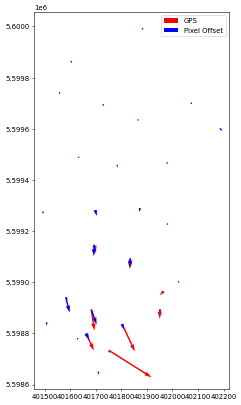

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

b = 20
bounds = [rang_rate.east.min()-b,rang_rate.east.max()+b,rang_rate.north.min()-b,rang_rate.north.max()+b]

options = dict(angles='xy',scale_units='xy',scale=0.066,width=0.0075)

fig, ax = plt.subplots(figsize=(10,10),dpi=50)

ax.quiver(rang_rate.east, rang_rate.north, rang_rate.e_rate, rang_rate.n_rate,color='red',label='GPS',**options)
ax.quiver(rang_rate.east, rang_rate.north, rang_rate.po_e_rate, rang_rate.po_n_rate,color='blue',label='Pixel Offset',**options)
ax.legend(loc='upper right', frameon=True)
ax.set_aspect('equal', 'box')

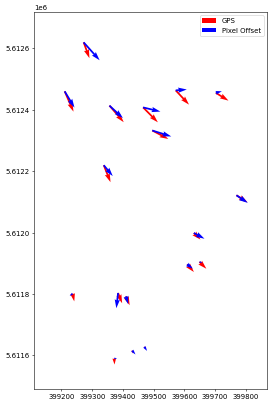

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

b = 100
bounds = [bird_rate.east.min()-b,bird_rate.east.max()+b,bird_rate.north.min()-b,bird_rate.north.max()+b]

options = dict(angles='xy',scale_units='xy',scale=0.066,width=0.0075)

fig, ax = plt.subplots(figsize=(10,10),dpi=50)

ax.quiver(bird_rate.east, bird_rate.north, bird_rate.e_rate, bird_rate.n_rate,color='red',label='GPS',**options)
ax.quiver(bird_rate.east, bird_rate.north, bird_rate.po_e_rate, bird_rate.po_n_rate,color='blue',label='Pixel Offset',**options)
ax.legend(loc='upper right', frameon=True)
ax.set_aspect('equal', 'box')
ax.set_xbound(lower=bounds[0],upper=bounds[1])
ax.set_ybound(lower=bounds[2],upper=bounds[3])

In [14]:
og_rang = rang_rate.copy()
rang_rate = rang_rate.loc[rang_rate.name != 'Peg 22']

og_rang = bird_rate.copy()
bird_rate = bird_rate.loc[bird_rate.name != 22]

In [15]:
rang_rate['mag_rate'] = np.sqrt((rang_rate.e_rate**2) + (rang_rate.n_rate**2))
rang_rate['po_mag_rate'] = np.sqrt((rang_rate.po_e_rate**2) + (rang_rate.po_n_rate**2))
rang_rate['location'] = 'rangitikei'

bird_rate['mag_rate'] = np.sqrt((bird_rate.e_rate**2) + (bird_rate.n_rate**2))
bird_rate['po_mag_rate'] = np.sqrt((bird_rate.po_e_rate**2) + (bird_rate.po_n_rate**2))
bird_rate['location'] = 'bird'

In [16]:
ls_rate = rang_rate.copy().append(bird_rate)

In [17]:
ls_rate.to_file('pot_rate_comparison.geojson')

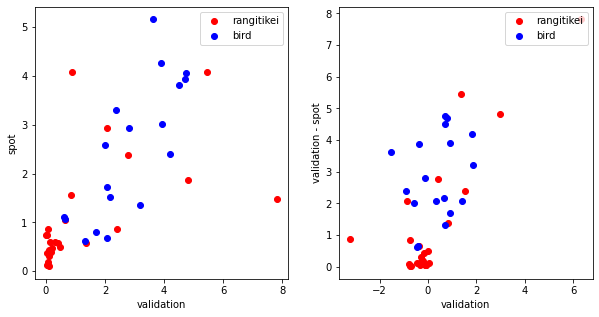

In [18]:
locs = {'rangitikei':'red','bird':'blue'}

f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

for l in locs:
    tmp = ls_rate.loc[ls_rate['location'] == l].copy()
    x = tmp.mag_rate
    y = tmp.po_mag_rate
    
    ax1.scatter(tmp.mag_rate,tmp.po_mag_rate,color=locs[l],label=l)
    ax1.set(xlabel='validation',ylabel='spot')
    
    ax2.scatter(x-y,x,color=locs[l],label=l)
    ax2.set(xlabel='validation',ylabel='validation - spot')

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

plt.savefig('/home/micromamba/scripts/po.png')

## Metrics

In [19]:
pegs = gpd.read_file('pot_rate_comparison.geojson')

pegs_sub = pegs.loc[~((pegs.location=='bird')&(pegs.name=='Peg 22') |
        (pegs.location=='rangitikei')&(pegs.name=='Peg 21'))]

In [20]:
po_error = pd.DataFrame(columns=['Site', 'Rate', 'N', 'Average Rate (m/yr)', 'MAE (m/yr)'])
groups = {'All':[-np.inf,np.inf],'< 1 m/yr':[-np.inf,1],'> 1 m/yr':[1,np.inf]}
sites = {'Rangitikei':['rangitikei'],'Bird':['bird'],'Both':['rangitikei','bird']}

for s,g in product(sites,groups):
    min_val,max_val = groups[g]
    loc = sites[s]
    tmp = pegs_sub.loc[(pegs_sub.mag_rate>min_val) & (pegs_sub.mag_rate<max_val) & pegs_sub.location.isin(loc)]
    
    avg_rate = tmp.mag_rate.mean()
    mae = mean_absolute_error(tmp.mag_rate, tmp.po_mag_rate)
    
    row = {'Site':s, 'Rate':g, 'N':tmp.shape[0], 'Average Rate (m/yr)':avg_rate, 'MAE (m/yr)':mae}
    po_error = po_error.append(row,ignore_index=True)

In [21]:
po_error

,Site,Rate,N,Average Rate (m/yr),MAE (m/yr)
0,Rangitikei,All,25,0.946923,0.681517
1,Rangitikei,< 1 m/yr,19,0.252128,0.478697
2,Rangitikei,> 1 m/yr,6,3.147106,1.323779
3,Bird,All,17,2.877358,0.836104
4,Bird,< 1 m/yr,2,0.644236,0.435875
5,Bird,> 1 m/yr,15,3.175107,0.889468
6,Both,All,42,1.728289,0.744088
7,Both,< 1 m/yr,21,0.289472,0.474619
8,Both,> 1 m/yr,21,3.167107,1.013557


In [22]:
po_error.to_csv('/home/micromamba/scripts/po.csv')